In [3]:
import scvelo as scv
import scanpy as sc

In [4]:
stromal_pal = {'Airway SMC (6)':'#1f77b4', 'Airway fibroblast progenitors (5)':'#ff7f0e', 'Chondrocyte (9)':'#2ca02c', 'Cycling fibroblasts (7)':'#d62728', 'Early fibroblasts (4)':'#9467bd', 'Lipofibroblast precursors (2)':'#8c564b', 'Lipofibroblasts (1)':'#e377c2', 'Uncommitted cells (3)':'#7f7f7f', 'Unknown stromal cells (10)':'#bcbd22', 'Vascular SMC (8)':'#17becf'} 

In [6]:
adata = sc.read('../../../../../../media/spencer/Extra HDD/lung_data/latentvelo_c1.h5ad')

In [7]:
import pandas as pd
import gc
meta = pd.read_csv('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c1_metadata.csv',
                  index_col=0)

adata.obs['id'] = [str(x.split('-')[0]) +'-'+ str(x.split('-')[1]) for x in adata.obs.index.values]
adata.obs = adata.obs.set_index('id')

adata.obs['cell_type'] = meta['cell_type_Aug']
gc.collect()

adata.obs['annotations'] = adata.obs['annotations'].cat.rename_categories({'Early fibroblasts': 'Early fibroblasts (4)', 
    'Lipofibroblast precursors': 'Lipofibroblast precursors (2)', 
    'Uncommitted endoderm cells': 'Uncommitted cells (3)', 
    'Airway fibroblast progenitors': 'Airway fibroblast progenitors (5)', 
    'Lipofibroblasts': 'Lipofibroblasts (1)', 'Airway SMC': 'Airway SMC (6)', 
    'Vascular SMC': 'Vascular SMC (8)', 'Cycling fibroblasts': 'Cycling fibroblasts (7)', 
    'Erythrocyte-like cells': 'Unknown stromal cells (10)', 'Chondrocyte': 'Chondrocyte (9)'})


adata.uns['paga']['groups'] = 'annotations'
adata.obs['cell_type'] = adata.obs.annotations

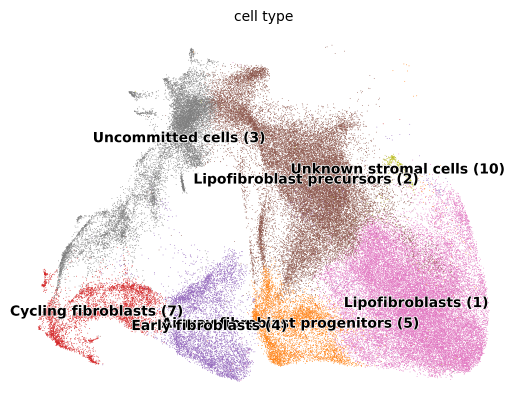

In [8]:
scv.pl.umap(adata, color='cell_type', palette=stromal_pal)

In [10]:
adata.obsm['X_latent'] = adata.layers['spliced']

In [11]:
sc.external.pp.bbknn(adata, neighbors_within_batch=2)

In [12]:
scv.tl.umap(adata, min_dist=0.1)

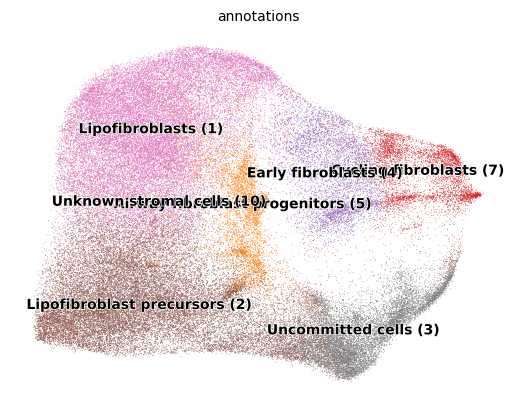

In [13]:
scv.pl.umap(adata, color='annotations', palette=stromal_pal)

In [13]:
import numpy as np
np.save('data/stromal_new_umap.npy',adata.obsm['X_umap'])

In [15]:
import numpy as np
import pandas as pd
def extract_paga_transitions(adata, key):
    clusters = adata.obs[key].cat.categories
    paga = np.array(adata.uns['paga']['transitions_confidence'].todense())
    paga_con = np.array(adata.uns['paga']['connectivities'].todense())
    transitions = []
    connectivities = []
    confidence = []
    for i in range(clusters.shape[0]):
        for j in range(clusters.shape[0]):
            if paga[i,j] > 0:
                transition = clusters[j] + '->' + clusters[i]
                transitions.append(transition)
                confidence.append(paga[i,j])
                connectivities.append(paga_con[i,j])
                
    return pd.DataFrame({'transition': transitions, 'confidence': confidence,
                        'connectivity': connectivities})

In [16]:

clusters = adata.obs['annotations'].cat.categories
paga = np.array(adata.uns['paga']['transitions_confidence'].todense())
paga_con = np.array(adata.uns['paga']['connectivities'].todense())
for i in range(clusters.shape[0]):
    for j in range(clusters.shape[0]):
        if paga_con[i,j] < 0.15:
            adata.uns['paga']['transitions_confidence'][i,j] = 0

In [15]:
del adata.obsm['spliced_velocity_umap']

computing velocity embedding
    finished (0:01:07) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/latentvelo_stromal_velocity_new_umap_smaller.pdf


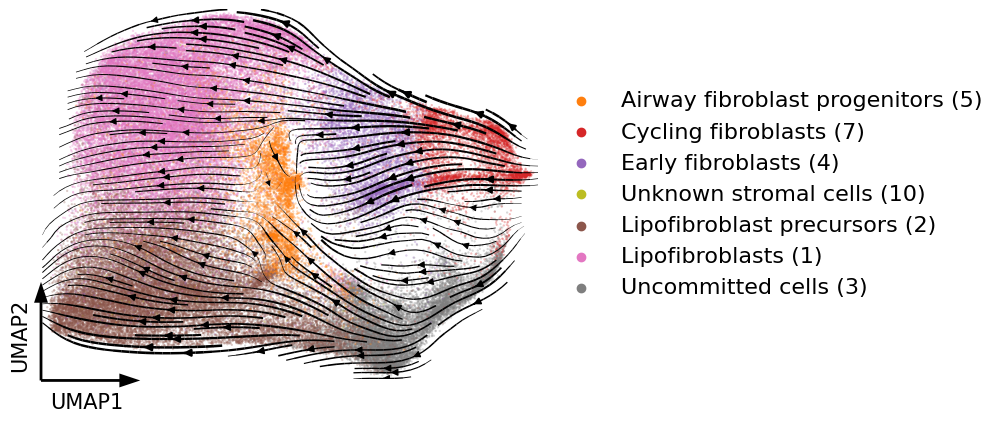

In [17]:
gc.collect()
scv.pl.velocity_embedding_stream(adata, vkey='spliced_velocity', 
                                 color=['cell_type'], frameon='artist', fontsize=18,
                                legend_loc='right', legend_fontsize=16, 
                                 title=[''], cutoff_perc=0.0, rasterized=True,#1, 
                               #scale=0.1,
                                 ncols=1, save='figures/latentvelo_stromal_velocity_new_umap_smaller.pdf',
                                palette = stromal_pal)#, 

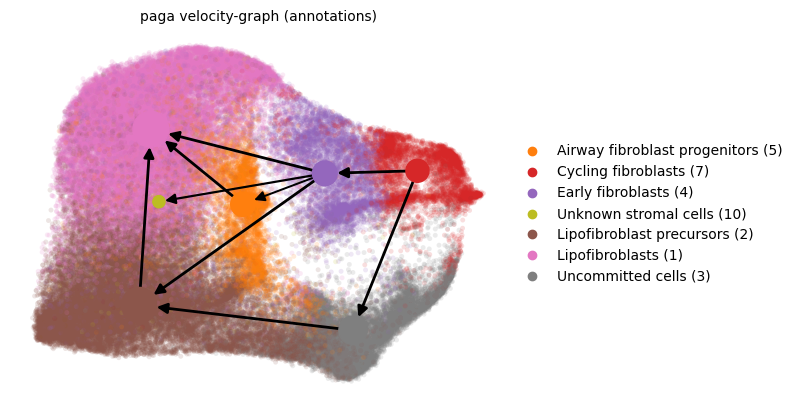

In [18]:
scv.pl.paga(adata, size=50, alpha=.15, basis='umap',
            edge_width_scale=2,
            min_edge_width=0, node_size_scale=2, threshold=0., #threshold=0.045, #threshold=0.025,
           dashed_edges = None)

In [19]:
extract_paga_transitions(adata, 'cell_type')

,transition,confidence,connectivity
0,Early fibroblasts (4)->Airway fibroblast proge...,0.095598,0.237038
1,Cycling fibroblasts (7)->Early fibroblasts (4),0.913022,1.000000
2,Early fibroblasts (4)->Unknown stromal cells (10),0.105274,0.542518
3,Early fibroblasts (4)->Lipofibroblast precurso...,0.620452,0.329372
4,Uncommitted cells (3)->Lipofibroblast precurso...,0.508087,0.366772
5,Airway fibroblast progenitors (5)->Lipofibrobl...,0.216871,0.382109
6,Early fibroblasts (4)->Lipofibroblasts (1),0.794593,0.408439
7,Lipofibroblast precursors (2)->Lipofibroblasts...,0.136180,0.239358
8,Cycling fibroblasts (7)->Uncommitted cells (3),0.222198,0.424300


In [20]:
pos = adata.uns['paga']['pos']

saving figure to file figures/latentvelo_stromal_PAGA_new_umap_smaller.pdf


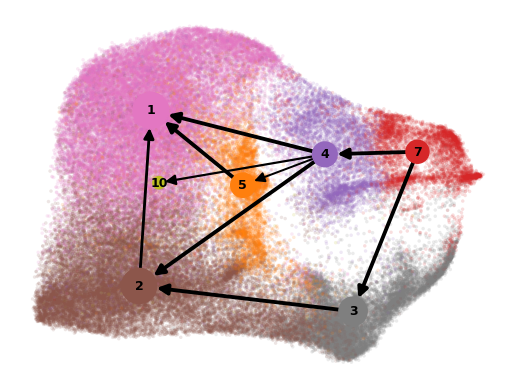

In [21]:
import numpy as np
gc.collect()
import matplotlib.pyplot as plt
fig,ax=plt.subplots()#figsize=(8,8))
scv.pl.paga(adata, size=50, alpha=.15, pos=pos, 
            edge_width_scale=2,max_edge_width=2.75,labels=None,
            min_edge_width=0, node_size_scale=2, threshold=0.,
           dashed_edges = None, ax=ax, show=False)
gc.collect()

for i,ct in enumerate(adata.obs.cell_type.cat.categories):
    X_emb = np.array(adata[adata.obs['cell_type']==ct].obsm['X_umap'])
    x_pos, y_pos = np.median(X_emb, axis=0) #
    label = ct[-4:].split('(')[1].split(')')[0]
    if label == '9' or label == '6':# or label=='10':
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', verticalalignment='center',
               color='white',fontweight='bold',fontsize=9)
    else:
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', 
                verticalalignment='center',fontweight='bold',fontsize=9)
scv.pl.umap(adata, color='cell_type', ax=ax, legend_loc='none',title='', alpha=0.15,palette = stromal_pal,
            rasterized=True,
            size=25,save='figures/latentvelo_stromal_PAGA_new_umap_smaller.pdf')
gc.collect()
plt.show()

In [28]:
np.save('new_umap.npy', adata.obsm['X_umap'])

In [23]:
pd.DataFrame(adata.uns['paga']['transitions_confidence'].todense(),index=adata.obs.cell_type.cat.categories, 
             columns=adata.obs.cell_type.cat.categories).to_csv('data/Stromal_PAGA.csv')